In [ ]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=a3985e2a-a28b-4fad-bc04-c7fca0c721e3
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:05<00:00, 33.3MB/s]


In [ ]:
!unzip -q vqa_coco_dataset.zip

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install bitsandbytes==0.45.0
!pip install accelerate==1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 108.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import LlavaForConditionalGeneration
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
from transformers import GenerationConfig
from PIL import Image

In [ ]:
def load_vqa_data(file_path):
    data = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split('\t')
            qa = temp[1].split('?')

            answer = qa[2].strip() if len(qa) == 3 else qa[1].strip()

            data_sample = {
                'image_path': temp[0][:-2],
                'question': qa[0] + '?',
                'answer': answer
            }
            data.append(data_sample)
    return data

train_data = load_vqa_data('vaq2.0.TrainImages.txt')
val_data = load_vqa_data('vaq2.0.DevImages.txt')
test_data = load_vqa_data('vaq2.0.TestImages.txt')

## **VQA model**

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id,
                                                      quantization_config=quantization_config,
                                                      device_map=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model.generation_config

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 32001
}

## **Create prompt**

In [ ]:
def create_prompt(question):
    prompt = f"""### INSTRUCTION:
Your task is to answer the question based on the given image. You can only answer 'yes' or 'no'.
### USER: <image>
{question}
### ASSISTANT:"""
    return prompt

In [ ]:
question = "what is this about?"
create_prompt(question)

"### INSTRUCTION:\nYour task is to answer the question based on the given image. You can only answer 'yes' or 'no'.\n### USER: <image>\nwhat is this about?\n### ASSISTANT:"

## **Inference**

In [ ]:
generation_config = GenerationConfig(
    max_new_tokens=10,
    do_sample=True,
    temperature=0.1,
    top_p=0.95,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token=model.config.pad_token_id,
)

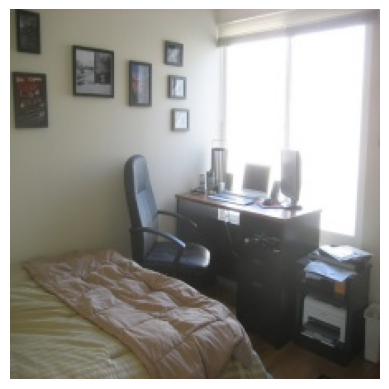

Question: Are there any boxes in the room ?
Label: no
Prediction:  No


In [ ]:
idx = 0
question = test_data[idx]['question']
image_name = test_data[idx]['image_path']
image_path = os.path.join('val2014-resised', image_name)
label = test_data[idx]['answer']
image = Image.open(image_path)

prompt = create_prompt(question)
inputs = processor(prompt,
                   image,
                   padding=True,
                   return_tensors="pt").to(device)

output = model.generate(**inputs,
                        generation_config=generation_config)
generated_text = processor.decode(output[0],
                                  skip_special_tokens=True)

plt.imshow(image)
plt.axis("off")
plt.show()
print(f"Question: {question}")
print(f"Label: {label}")
print(f"Prediction: {generated_text.split('### ASSISTANT:')[-1]}")